In [3]:
import numpy as np
#from scipy.integrate import solve_ivp
#from scipy.signal import spectrogram
import matplotlib.pyplot as plt
#from piaxi_numerics import set_params, solve_system, get_text_params

verbosity = 9
use_tex_format = True

In [4]:
# LaTeX Formatting for Plots
if use_tex_format:
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

    SMALL_SIZE = 8
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    '''plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the x tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)  # fontsize of the figure title'''

In [3]:
# TODO
sklearn_process = False
if sklearn_process:
    from sklearn.neural_network import MLPClassifier, MLPRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC

    ## TODO: Data generation, importing, and preprocessing

    # TODO: load dataset
    from sklearn.datasets import make_classification
    X, y = make_classification(random_state = 0, n_features = 20, n_informative = 18, n_classes = 3)

    # TODO: split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [4]:
# TODO
if sklearn_process:
    # Create dataset processing and classification pipeline
    model_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
    model_mlp = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(max_iter=400))])
    models = [model_svc, model_mlp]

    # Fit model to training dataset
    for model in models:
        print(list(model.named_steps.keys())[1])
        model.fit(X_train, y_train)
        # Evaluate fit with test dataset
        print("Score: %.2f" % model.score(X_test, y_test))
        print(" --------------------------------------- ")

In [5]:
from piaxi_utils import fit_crude_epsilon_relation, fit_Fpi
fit_eps = False
eps = 1.
if fit_eps:
    pts = [(0.1,-19.9,eps), (0.5,-18.6,eps), (1,-17.9,eps)]
    fit_res, _ = fit_crude_epsilon_relation(pts_in=pts, plot_fit=True)
    if verbosity >= 0:
        print('y = %.3f log_10(10x + %.3f) + %.3f' % (fit_res[0], fit_res[1], fit_res[2]))

In [6]:
fit_F = False

if fit_F:
    Fpi = fit_Fpi(1.0, 1e-20)

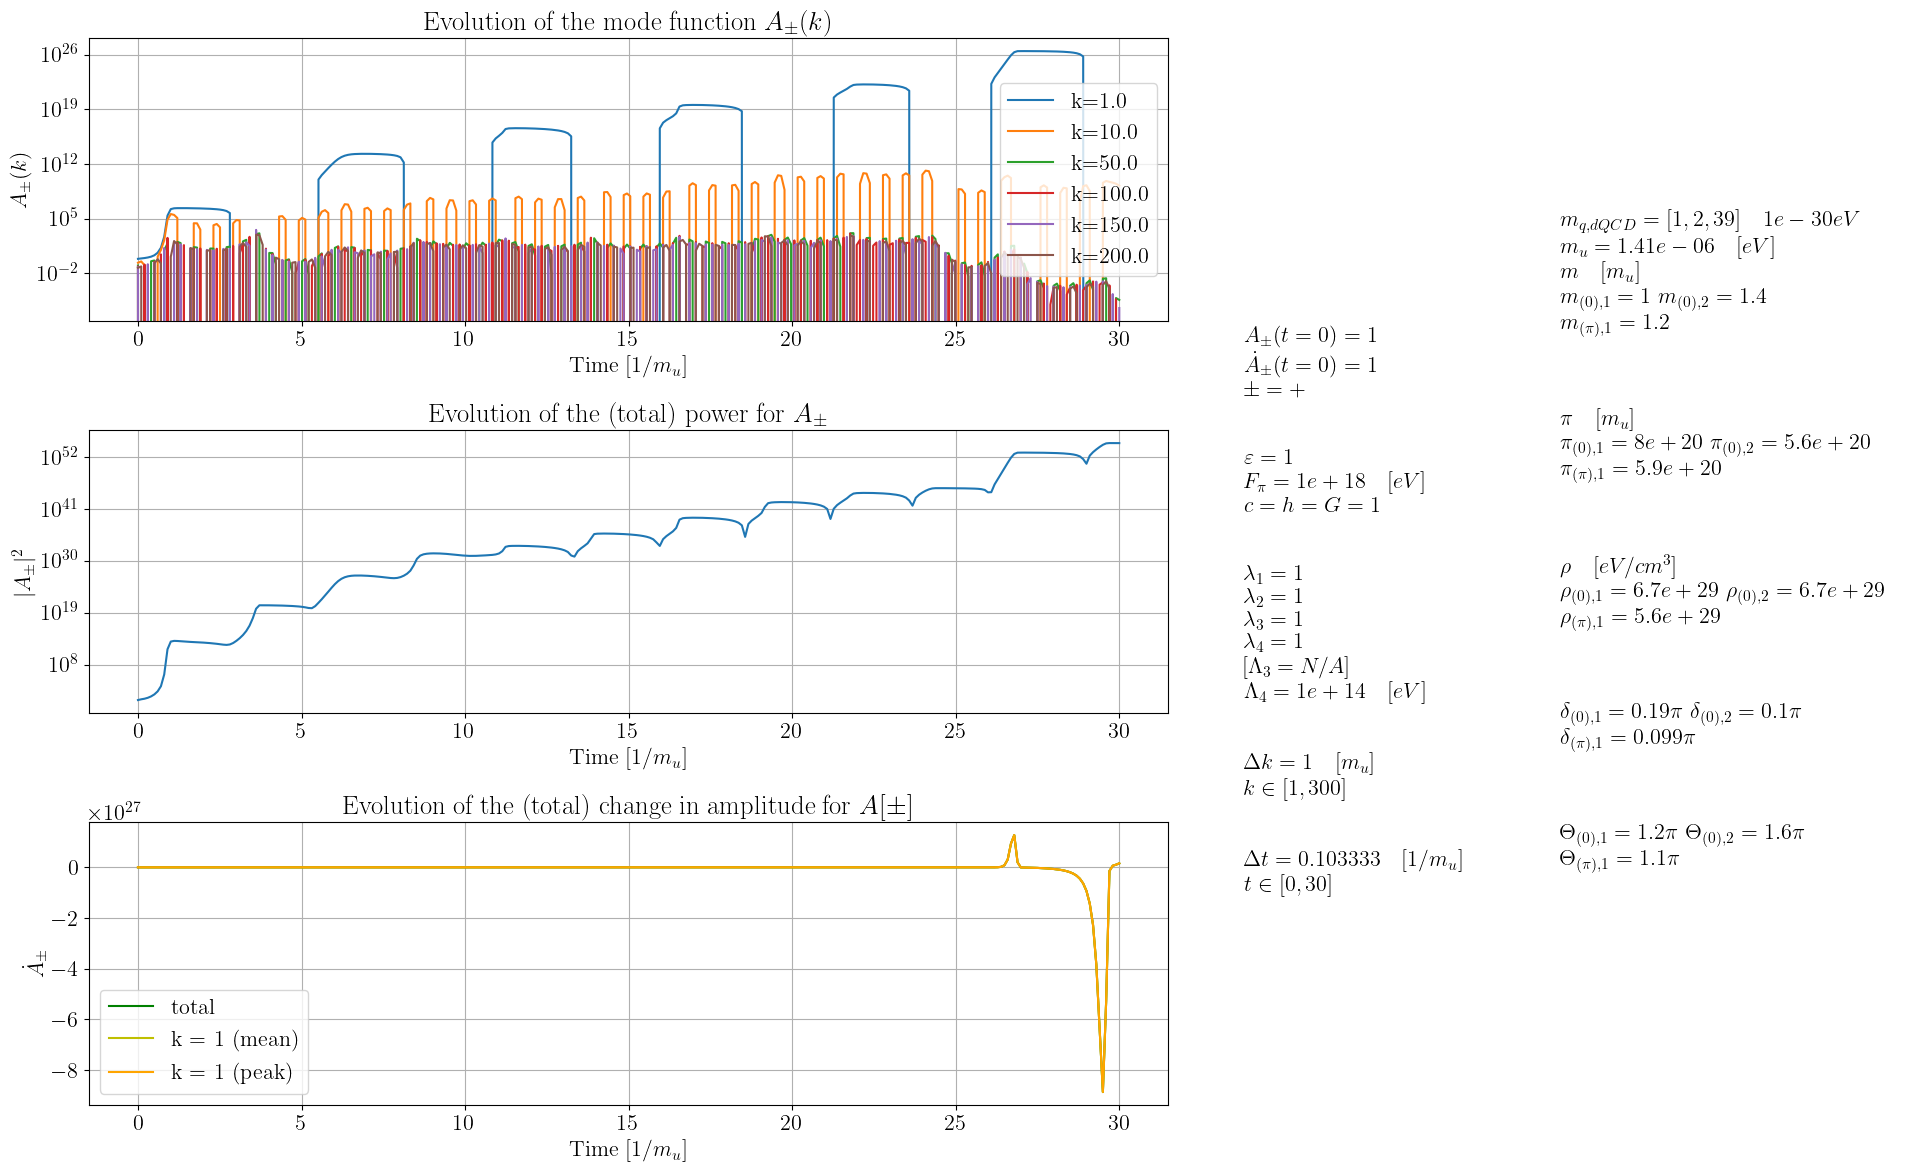

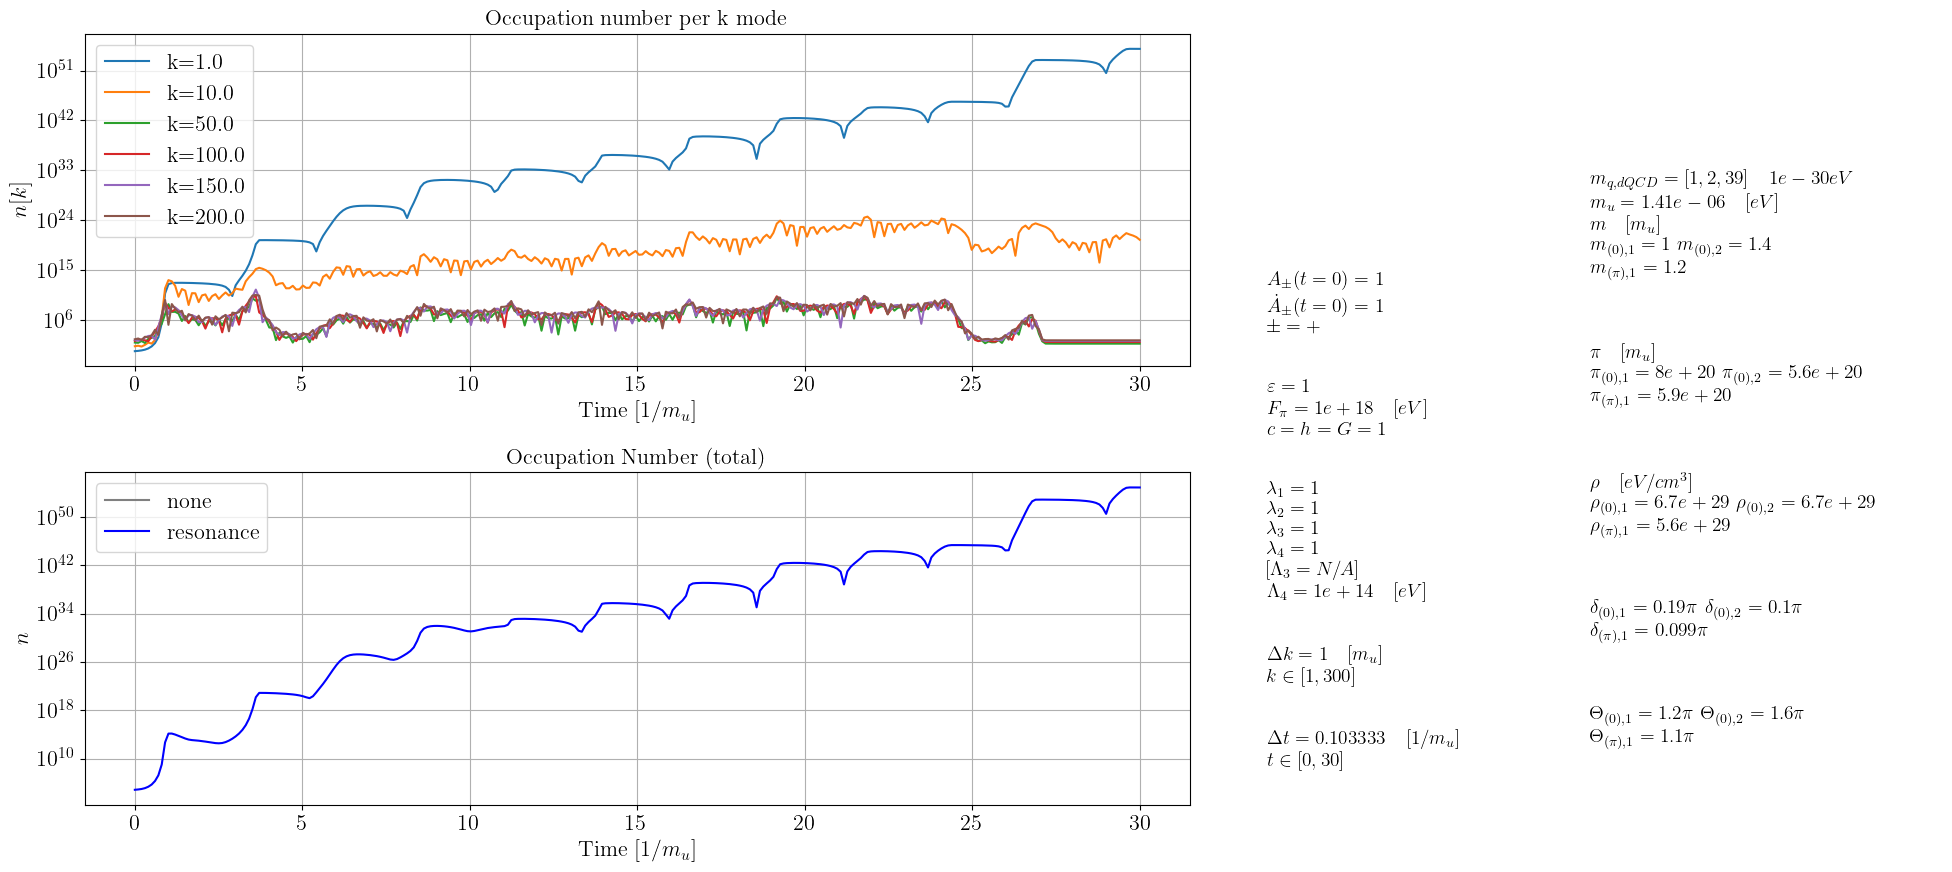

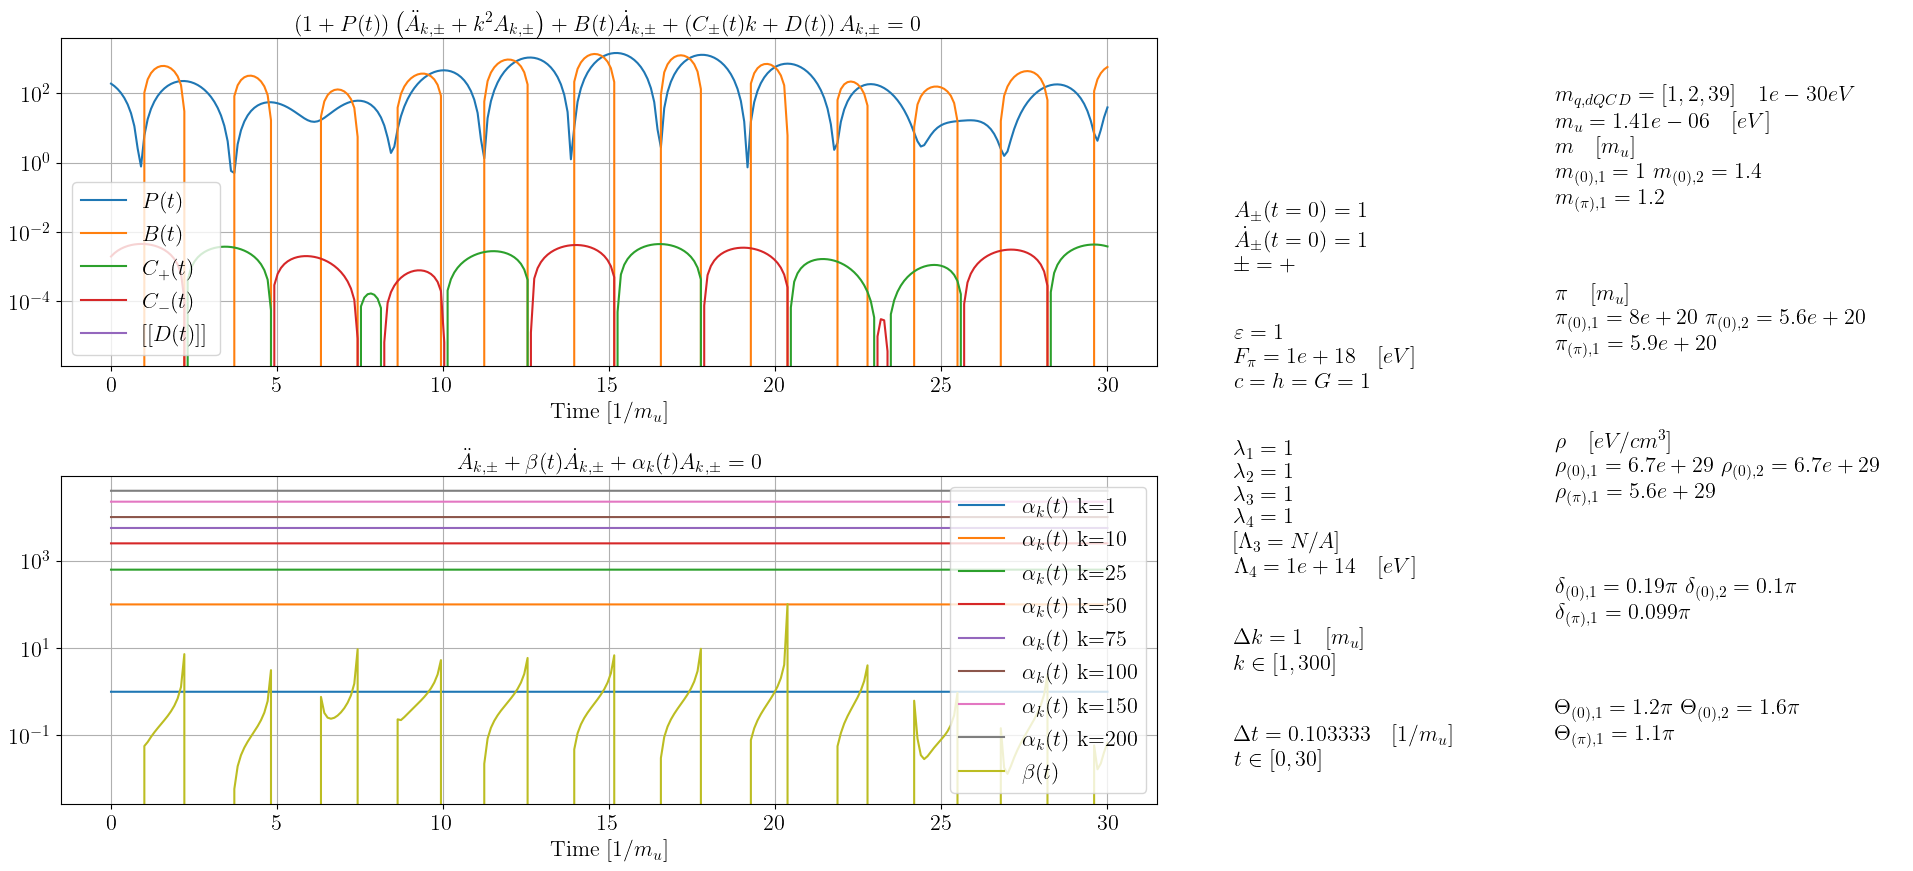

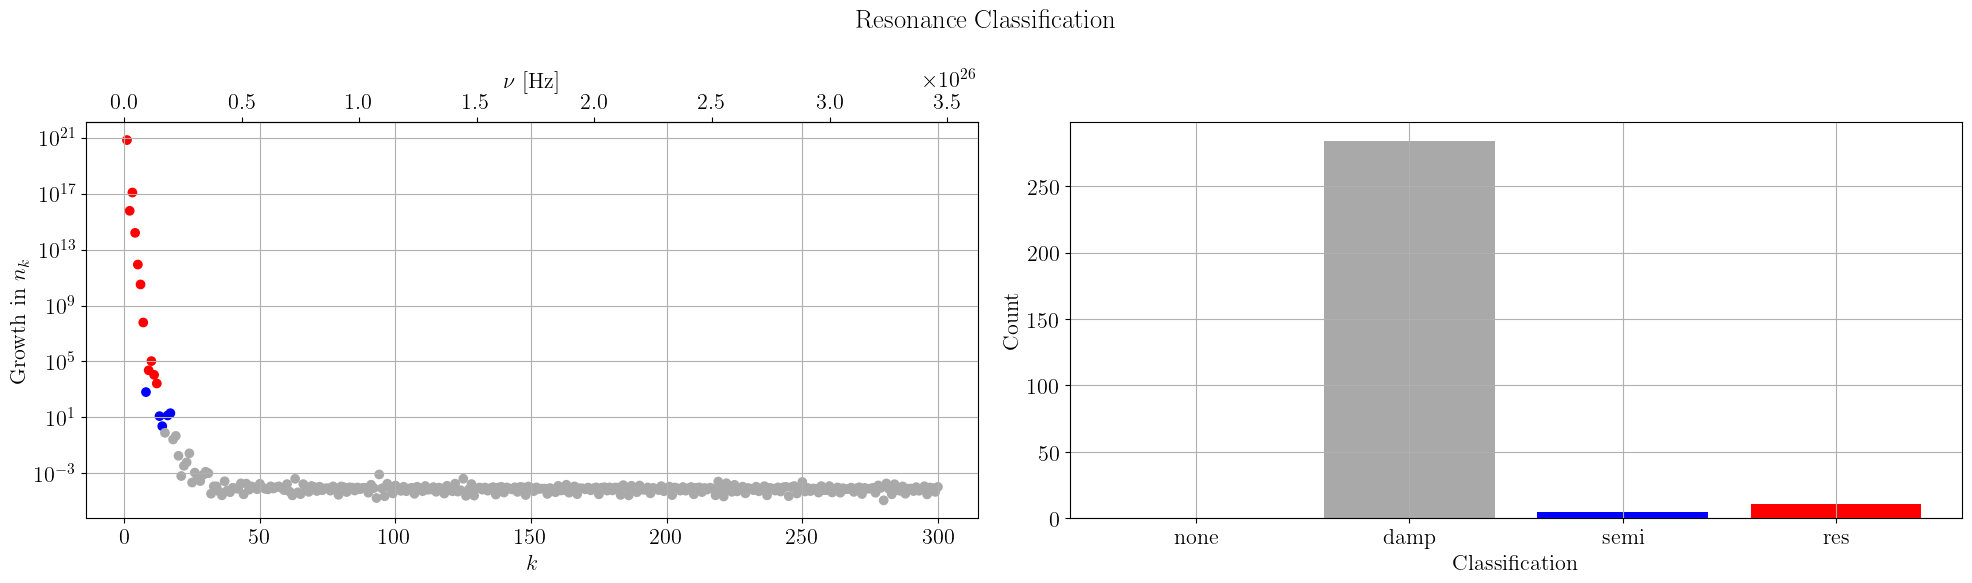

In [5]:
from piaxi_utils import plot_single_case, load_single_result

#plot_single_case('3_neutrals_5f6d4c42050e31fa8d06ce7d9fc526e1eff881f3.json', output_dir='./test_data/', version='v2.8', tex_fmt=use_tex_format)
plot_single_case('debug_bbbcfee89c436a9c11885e23159ef57a33e53985.json', output_dir='./scratch/', tex_fmt=use_tex_format)
                 

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from piaxi_utils import load_all

#np.warnings.filterwarnings("error", category=np.VisibleDeprecationWarning)

def prepare_data(config_name, output_root='~/scratch', version='v3.2'):
    """Load and prepare data for future functions"""
    
    params, results, _, coeffs = load_all(config_name, output_root, version)
    
    # Convert to DataFrames for ease of manipulation
    params_df  = pd.DataFrame(params)
    # Set dtypes for each column
    dtype_map = {
        "A_0": np.float32,
        "A_pm": np.int32,
        "A_sens": np.float32,
        "Adot_0": np.float32,
        "F": np.float32,
        "G": np.float32,
        "L3": np.float32,
        "L4": np.float32,
        "N_c": np.int32,
        "N_n": np.int32,
        "N_r": np.int32,
        "Th": np.ndarray,
        "amps": np.ndarray,
        "c": np.float32,
        "d": np.ndarray,
        "dqm": np.ndarray,
        "e": np.float32,
        "eps": np.float32,
        "eps_c": np.ndarray,
        "h": np.float32,
        "int_method": str,
        "jupyter": 'Int64',
        "k_0": np.float32,
        "k_class_arr": 'object',
        "k_mean_arr": np.ndarray,
        "k_num": np.int32,
        "k_peak_arr": np.ndarray,
        "k_sens_arr": np.ndarray,
        "k_span": np.ndarray,
        "l1": np.int32,
        "l2": np.int32,
        "l3": np.int32,
        "l4": np.int32,
        "m": np.ndarray,
        "m_0": np.float32,
        "m_c": np.ndarray,
        "m_n": np.ndarray,
        "m_q": np.float32,
        "m_r": np.ndarray,
        "m_u": np.float32,
        "mu_Th": np.float32,
        "mu_d": np.float32,
        "num_cores": np.int32,
        "p": np.ndarray,
        "p_0": np.float32,
        "p_c": np.ndarray,
        "p_n": np.ndarray,
        "p_r": np.ndarray,
        "p_t": np.float32,
        "parallel": bool,
        "qc": np.ndarray,
        "qm": np.ndarray,
        "res_band": np.ndarray,
        "res_band_class": str,
        "res_class": str,
        "res_con": np.float32,
        "res_freq": np.float32,
        "res_freq_class": str,
        "res_freq_label": str,
        "rescale_amps": bool,
        "rescale_consts": bool,
        "rescale_k": bool,
        "rescale_m": bool,
        "seed": str,
        "sig_Th": np.float32,
        "sig_d": np.float32,
        "t_num": np.int32,
        "t_res": np.float32,
        "t_sens": np.float32,
        "t_span": np.ndarray,
        "t_u": np.float32,
        "use_natural_units": bool,
        "use_mass_units": bool,
        "dimensionful_p": bool,
        "time_elapsed": str,
        "unitful_amps": bool,
        "unitful_k": bool,
        "unitful_m": bool,
        "xi": np.ndarray
    }
    
    # TODO: Temp fix, remove this when no longer needed
    if int(version.split('.')[1]) <= 9:
        params_df['jupyter'].fillna(False, inplace=True)

    for col, dtype in dtype_map.items():
        try:
            if dtype is np.ndarray:
                try:
                    params_df[col] = params_df[col].apply(np.array, dtype=object)
                except (np.VisibleDeprecationWarning):
                    print('Deprecation: %s' % col)
                    print(params_df[col])
                    params_df[col] = params_df[col].apply(np.array)
            else:
                params_df[col] = params_df[col].astype(dtype)
        except (OverflowError):
            print(col, dtype)
    
    res_arr = np.array(results[0], dtype=np.float64)[:,0,:]
    results_df = pd.DataFrame(res_arr)
    
    coeffs_df  = pd.DataFrame(coeffs)
    
    return params_df, results_df, coeffs_df


def plot_heatmaps(df):
    """Plot heatmaps of k_class_arr, k_sens_arr, and k_peak_arr over multiple runs."""
    
    # Assuming the arrays are already in the correct format
    k_class_arr = df['k_class_arr']
    k_sens_arr  = df['k_sens_arr']
    k_peak_arr  = df['k_peak_arr']
    k_spans     = df['k_span']

    # Determine the global k-range
    global_k_min = min([span[0] for span in k_spans])
    global_k_max = max([span[1] for span in k_spans])
    total_k_modes = max([len(arr) for arr in k_class_arr])  # maximum number of k-modes
    
    # Convert string values to unique integers for plotting
    unique_values = np.unique(np.concatenate(k_class_arr))
    num_runs   = len(k_class_arr)
    num_values = len(k_class_arr[0])
    value_to_int = {value: idx for idx, value in enumerate(unique_values)}
    
    #k_class_arr = [[value_to_int[val] for val in row] for row in k_class_arr]
    #k_sens_arr  = [[val for val in row] for row in k_sens_arr]
    #k_peak_arr  = [[val for val in row] for row in k_peak_arr]
    
    if True:
        # Initialize combined heatmaps
        combined_k_class = np.full((len(k_class_arr), total_k_modes), np.nan)
        combined_k_sens  = np.full((len(k_sens_arr), total_k_modes), np.nan)
        combined_k_peak  = np.full((len(k_peak_arr), total_k_modes), np.nan)
        
        k_sens_min = k_sens_max = k_peak_min = k_peak_max = None

        # Fill in the combined heatmaps
        for idx, (k_class, k_sens, k_peak, k_span) in enumerate(zip(k_class_arr, k_sens_arr, k_peak_arr, k_spans)):
            start_idx = int((k_span[0] - global_k_min) * total_k_modes / (global_k_max - global_k_min))
            end_idx = start_idx + len(k_class)
            combined_k_class[idx, start_idx:end_idx] = [value_to_int[val] for val in k_class]
            combined_k_sens[idx, start_idx:end_idx] = k_sens
            combined_k_peak[idx, start_idx:end_idx] = k_peak
            
            k_sens_min = min(k_sens) if k_sens_min is None else min(k_sens_min, min(k_sens))
            k_sens_max = max(k_sens) if k_sens_max is None else max(k_sens_max, max(k_sens))
            k_peak_min = min(k_peak) if k_peak_min is None else min(k_peak_min, min(k_peak))
            k_peak_max = max(k_peak) if k_peak_max is None else max(k_peak_max, max(k_peak))

        # Plot the combined heatmaps
        plt.figure(figsize=(10, 12))
        ax1 = plt.subplot(3, 1, 1)
        im1 = plt.imshow(combined_k_class, aspect='auto', cmap='viridis')
        plt.title("k_class_arr")

        ax2 = plt.subplot(3, 1, 2)
        im2 = plt.imshow(combined_k_sens, aspect='auto', cmap='autumn')
        plt.title("k_sens_arr")

        ax3 = plt.subplot(3, 1, 3)
        im3 = plt.imshow(combined_k_peak, aspect='auto', cmap='autumn')
        plt.title("k_peak_arr")
        
        # Add colorbars to indicate the mapping from integers back to string values
        cbar1 = plt.colorbar(im1, ax=ax1, ticks=list(value_to_int.values()))
        cbar1.set_ticklabels(list(value_to_int.keys()))

        cbar2 = plt.colorbar(im2, ax=ax2, ticks=np.linspace(k_sens_min, k_sens_max, 3))
        #cbar2.set_ticklabels(list(value_to_int.keys()))

        cbar3 = plt.colorbar(im3, ax=ax3, ticks=np.linspace(k_peak_min, k_peak_max, 3))
        #cbar3.set_ticklabels(list(value_to_int.keys()))
        

        plt.tight_layout()
        plt.show()
        
    else:
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))

        im1 = axs[0].imshow(k_class_arr, aspect='auto', cmap='viridis')
        axs[0].set_title('k_class_arr heatmap')
        axs[0].set_xlabel('Index')
        axs[0].set_ylabel('Run')

        im2 = axs[1].imshow(k_sens_arr, aspect='auto', cmap='autumn')
        axs[1].set_title('k_sens_arr heatmap')
        axs[1].set_xlabel('Index')
        axs[1].set_ylabel('Run')

        im3 = axs[2].imshow(k_peak_arr, aspect='auto', cmap='autumn')
        axs[2].set_title('k_peak_arr heatmap')
        axs[2].set_xlabel('Index')
        axs[2].set_ylabel('Run')

        # Add colorbars to indicate the mapping from integers back to string values
        cbar1 = plt.colorbar(im1, ax=axs[0], ticks=list(value_to_int.values()))
        cbar1.set_ticklabels(list(value_to_int.keys()))

        cbar2 = plt.colorbar(im2, ax=axs[1], ticks=list(value_to_int.values()))
        cbar2.set_ticklabels(list(value_to_int.keys()))

        cbar3 = plt.colorbar(im3, ax=axs[2], ticks=list(value_to_int.values()))
        cbar3.set_ticklabels(list(value_to_int.keys()))

        plt.tight_layout()
        plt.show()

def plot_scatter(df):
    """Plot m_r vs F and p_t vs Lambda4 scatter plots over multiple runs, labeled by res_class."""
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    unique_classes = df['res_class'].unique()
    
    for res_cls in unique_classes:
        subset = df[df['res_class'] == res_cls]
        
        axs[0].scatter(subset['F'], subset['m_r'].str[0], label=f'Res Class {res_cls}')
        axs[1].scatter(subset['L4'], subset['p_t'], label=f'Res Class {res_cls}')
    
    axs[0].set_title('m_r vs F')
    axs[0].set_xlabel('F')
    axs[0].set_ylabel('m_r')
    
    axs[1].set_title('p_t vs Lambda4')
    axs[1].set_xlabel('Lambda4 (L4)')
    axs[1].set_ylabel('p_t')
    
    axs[0].legend()
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
params_data, results_data, coeffs_data = prepare_data('debug')
print(params_data.columns)
plot_heatmaps(params_data)
plot_scatter(params_data)

In [ ]:
## Analyze a run's plots TODO/WIP
if False:

    # Sample data (replace with actual data)
    #params, results, _, coeffs = load_single_result(filename='3_neutrals_5f6d4c42050e31fa8d06ce7d9fc526e1eff881f3', output_dir='./test_data/v2.8/3_neutrals/')
    

    # Placeholder for raw solution (replace with actual data when available)
    data = params_data
    raw_solution = results_data
    print(results_data)

    # Heatmap for raw solution
    plt.figure(figsize=(12, 8))
    sns.heatmap(raw_solution, cmap='viridis')
    plt.title("Heatmap of Raw Solution (Amplitude of Photon Field)")
    plt.xlabel("k-mode")
    plt.ylabel("Time")
    plt.show()

    # Bar plots for k_mean_arr, k_peak_arr, and k_sens_arr
    k_modes = np.arange(1, len(data["k_mean_arr"]) + 1)
    plt.figure(figsize=(12, 8))
    plt.bar(k_modes, data["k_mean_arr"], label="k_mean_arr", alpha=0.6)
    plt.bar(k_modes, data["k_peak_arr"], label="k_peak_arr", alpha=0.6)
    plt.bar(k_modes, data["k_sens_arr"], label="k_sens_arr", alpha=0.6)
    plt.xlabel("k-mode")
    plt.ylabel("Value")
    plt.title("Bar Plots for k_mean_arr, k_peak_arr, and k_sens_arr")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Categorical plot for k_class_arr
    plt.figure(figsize=(12, 8))
    sns.countplot(data["k_class_arr"])
    plt.title("Distribution of Classification Labels")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_k_vs_parameter_heatmap(df, parameter, mode='absolute'):
    # Extract global k range
    global_k_min = df['k_span'].apply(lambda x: x[0]).min()
    global_k_max = df['k_span'].apply(lambda x: x[1]).max()
    k_values = np.linspace(global_k_min, global_k_max, 500)  # Sampled k-values

    param_values = df[parameter].unique()
    heatmap_grid = np.zeros((len(param_values), len(k_values)))

    for i, param_val in enumerate(param_values):
        subset = df[df[parameter] == param_val]
        for j, k_val in enumerate(k_values):
            count = 0
            for _, row in subset.iterrows():
                k_min, k_max = row['k_span']
                if k_val >= k_min and k_val <= k_max:
                    index = np.argmin(np.abs(row['k_sens_arr'] - k_val))
                    if row['k_class_arr'][index] == 'res':
                        count += 1
            if mode == 'fraction':
                count /= len(subset)
            heatmap_grid[i, j] = count

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_grid, xticklabels=50, yticklabels=param_values, cmap="YlGnBu")
    plt.xlabel('k-values')
    plt.ylabel(parameter)
    title = f"Heatmap of 'res' count in k_class_arr vs. {parameter}"
    if mode == 'fraction':
        title += " (fraction)"
    plt.title(title)
    plt.show()


In [ ]:
plot_k_vs_parameter_heatmap(params_data, 'm_u')
plot_k_vs_parameter_heatmap(params_data, 'F')
plot_k_vs_parameter_heatmap(params_data, 'L4')
plot_k_vs_parameter_heatmap(params_data, 'p_t')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Convert your dictionary to DataFrame for ease of manipulation
df_in = params_data.copy(deep=True)

# Expand array-like features into discrete columns
df = pd.concat([df_in, df_in.pop("qc").apply(pd.Series).add_prefix("qc_")], axis=1)

# Descriptive Statistics
if True:
    print(df.describe())
print('-----------------------------------------------------------------')

# Organize parameters
performance_inputs = ['num_cores', 'jupyter', 'parallel', 'use_mass_units', 'use_natural_units', 'k_num', 't_num', 'N_r', 'N_c', 'N_n', 'p_t', 'F', 'm_q']
performance_outputs = ['time_elapsed']
performance_params = performance_inputs + performance_outputs
time_param_set = set(performance_params)

primary_inputs = ['F', 'm_q', 'eps', 'p_t', 'use_mass_units', 'use_natural_units', 'qc']
secondary_inputs = ['A_0', 'A_pm', 'k_num', 't_num', 'mu_Th', 'mu_d', 'sig_Th', 'sig_d', 'xi']
primary_outputs = ['res_class', 'res_band_class']
secondary_outputs = ['res_band', 'res_freq', 't_res']
correlation_params = primary_inputs + secondary_inputs + primary_outputs + secondary_outputs
corr_param_set = set(correlation_params)

combined_params = correlation_params + performance_params
combined_param_set = set(combined_params)

if True: # Temp. prune parameters not found in older datasets
    new_params = ['qc', 'res_freq', 'use_natural_units', 'res_band', 'use_mass_units', 'res_band_class']
    for new_param in new_params:
        if new_param not in df.columns:
            if new_param in corr_param_set:
                corr_param_set.remove(new_param)
            if new_param in time_param_set:
                time_param_set.remove(new_param)
            if new_param in combined_param_set:
                combined_param_set.remove(new_param)

main_df = df[sorted(combined_param_set)]
corr_df = df[sorted(corr_param_set)]
time_df = df[sorted(time_param_set)]

# Correlation Analysis
print('Model Parameter Correlations')
print(corr_df.describe())
correlation_matrix = corr_df.corr()
print(correlation_matrix)
print('-----------------------------------------------------------------')

# Complexity Analysis
print('Time Complexity Correlations')
print(time_df.describe())
time_corr_matrix = time_df.corr()
print(time_corr_matrix)
print('-----------------------------------------------------------------')

# Visualization
# Histograms
for column in corr_df.columns:
    plt.hist(corr_df[column])
    plt.title(column)
    plt.show()

# Scatter plots
sns.pairplot(corr_df)

# Heatmap for correlation matrix
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [ ]:
# Split data into train and test
train, test = train_test_split(df, test_size=0.3)

# Separate inputs and outputs
output_params = ['res_class', 'time_elapsed']
#output_params = ['res_class', 'res_freq_class', 'res_band_class', 'time_elapsed']
X_train = train.drop(columns=output_params)
y_train = train[output_params]
X_test = test.drop(columns=output_params)
y_test = test[output_params]

# Model training and prediction
clf = RandomForestClassifier()
clf.fit(X_train, y_train['res_class'])  # For 'res_class', repeat for others

# Feature Importance
importance = clf.feature_importances_
# Plot feature importance
sns.barplot(x=importance, y=X_train.columns)

# Visualization
# Pair plot for m_r, m_n, m_c, F
sns.pairplot(df[['m_r', 'm_n', 'm_c', 'F']])
plt.show()


In [ ]:
## Optical Depth Calculations
import numpy as np
c = 2.998e10   # [cm/s]
h = 6.582e-16  # [eV s]
G = 6.674e-13  # [N cm^2/g^2]

## Scattering Cross-Section
k_example = 1          # [m]  =  3.85e+13 [Hz]
m_example = 1          # [m]
u_example = 1.414e-06  # [eV]
coupling_example = 1
cutoff_example = 1e5   # [eV]

cs_to_units = lambda cs: cs * (h ** 2) * (c**3)
# crossterm FFdual
cross_sec_1 = lambda k=k_example, m=m_example, l=coupling_example, L=cutoff_example, c=c, h=h, G=G: (((l ** 2) * m)/(6*np.pi*(L**4))) * ((k ** 4)/((m + 2*k)**3))
# pi_0 FFdual
cross_sec_0 = lambda k=k_example, m=m_example, l=coupling_example, L=cutoff_example, c=c, h=h, G=G: 0

print('Example cross-section values:')
#print('   sigma_0 = %.3e [eV]^-2 = %.3e [cm]^2' % (cross_sec_0(), cs_to_units(cross_sec_0())))
print('   sigma_1 = %.3e [eV]^-2 = %.3e [cm]^2' % (cross_sec_1(), cs_to_units(cross_sec_1())))

## Optical Depth
density_example = 1e31   # [eV/cm^3]

# Simple optical depth calculation (tau = sigma * n)
tau_simple = lambda cs, rho=density_example, m_u=u_example, c=c: (rho*c**2)/m_u * cs_to_units(cs)
# Weinberg calculation
tau_weinberg = lambda cs, rho=density_example, m_u=u_example, k_peak=k_example, k_step=1, k_max=cutoff_example, c=c: ((rho*c**2)/m_u) / ((m_u*c)*k_peak*h) * np.sum(np.arange(1,cutoff_example,k_step))

print('\nExample optical depth values:')
#print('   tau_0 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_0()))
#print('   tau_0 (weinberg) = %.3e [cm]^-1' % tau_weinberg(cross_sec_0()))
print('   tau_1 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_1()))
print('   tau_1 (weinberg) = %.3e [???]' % tau_weinberg(cross_sec_1()))

In [ ]:
### Length Scales of different astrophysical scenarios
##       - TODO:  Axion minicluster (planetary), Axion star, axion clump (~5 parsec), axion DM galaxy halo, galaxy supercluster-sized halo

## TODO: - Compare different length scales and energy density values against optical depth.
##       - Sanity check to ensure that optical depth is not too high

M_sun    = 1.988e33    # [g]
g_to_eV  = 5.61e32     # [eV]
pc_to_cm = 3.086e18    # [cm]

## Axion Stars
R_star = 1.          # [cm], can be determined by mass
M_star = 1.          # [m_sun], can be determined by radius
# ALP properties
m_axion = (m_example * u_example)
g_axion = (coupling_example / cutoff_example)
# axion decay constant
f_axion = 1.
# initial axion field amplitude
a_0 = 1.

# Axion star radius relations (Iwazaki 2022)
# note: per above, R_star ~ 1/k_axion
fixed_M = True
if fixed_M:
    R_star = 1./(G * m_axion**2 * (M_star*M_sun))
else:
    M_star = (np.pi * (1./2) * (m_axion/g_to_eV)**2 * f_axion**2 * a_0**2 * R_star**3) / M_sun

# Critical Coupling (Chung-Jukko 2023)
# (values of coupling constant above this will rapidly decay via parametric resonance)
g_crit = (1.66e-17)/(1e9) * ((M_star)*(m_axion/1e-11))**(-1.35)     # [eV]^-1
# (timescale of decay)
t_crit = (g_axion - g_crit)**(-0.87)     # [TODO: units???]

# Axion star energy density
rho_star = (M_star*M_sun*g_to_eV)/((4/3)*np.pi*R_star**3)    # [eV / cm^3]

# Axion star optical properties:
print('Axion Star:')
print('   M = %.1f [m_sun]   |   R = %.3e [cm]   |   rho = %.3e [eV/cm^3]  |   m_a = %.3e [eV]   |   g_crit = %0.1e [eV]^-1' % (M_star, R_star, rho_star, m_axion, g_crit))
print('Optical Depth: ')
#print('   tau_0 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_0(), rho=rho_star, m_u=m_axion))
#print('   tau_0 (weinberg) = %.3e [cm]^-1' % tau_weinberg(cross_sec_0(), rho=rho_star, m_u=m_axion))
print('   tau_1 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_1(), rho=rho_star, m_u=m_axion))
print('   tau(R) = %.3e' % (tau_simple(cross_sec_1(), rho=rho_star, m_u=m_axion)*R_star))
print('   tau_1 (weinberg) = %.3e [???]' % tau_weinberg(cross_sec_1(), rho=rho_star, m_u=m_axion))
print('   tau(R) = %.3e' % (tau_weinberg(cross_sec_1(), rho=rho_star, m_u=m_axion)*R_star))

## TODO: Axion Miniclusters

## TODO: Axion Halos

In [ ]:
### TODO: Dispersion and Birefringence Effects

# neutral (real), neutral (complex), and charged species masses in [eV]
N_r = 5; N_n = 6; N_c = 9
example_m_r = 1e-5  # [eV]
example_m_n = 2e-5  # [eV]
example_m_c = 3e-5  # [eV]

# parameters of theory
l1 = l2 = l3 = l4 = 1.  # unitless
L3 = L4 = 1e11          # [eV]
example_eps = 1.        # unitless
example_Fpi = 1e21      # [eV]
unitless_e  = 0.3       # unitless electron charge
M_planck = np.sqrt(h*2*np.pi*c/G)

# example species sets
example_masses = [example_m_r]*N_r + [example_m_n]*N_n + [example_m_c]*N_c
example_amps = [2*np.sqrt(density_example)/example_m_r]*N_r + [2*np.sqrt(density_example)/example_m_n]*N_n + [2*np.sqrt(density_example)/example_m_c]*N_c
example_phases = [0.]*N_r + [0.]*N_n + [0.]*N_c
example_lambdas = [l3]*N_r + [l3]*N_n + [l4]*N_c
example_Lambdas = [L3]*N_r + [L3]*N_n + [L4]*N_c

## Fine Structure Constant corrections
# (include sum over all surviving species, where lambda(3 or 4) and Lambda(3 or 4) are determined by neutral/charged species)
fine_structure_constant = lambda t, lambdas, Lambdas, e, eps, amps, masses, phases, fs=(1./137): \
    fs * (1 + (2*(e**2))*(eps**2)*np.sum([(l_i)/(L_i**2) * np.abs(amp_i)**2 * np.cos(m_i*t + d_i)**2 for amp_i, m_i, d_i, l_i, L_i in zip(amps, masses, phases, lambdas, Lambdas)]))
alpha_e = lambda t: fine_structure_constant(t, lambdas=example_lambdas, Lambdas=example_Lambdas, e=unitless_e, eps=example_eps, amps=example_amps, masses=example_masses, phases=example_phases)

## TODO: Dispersion relations in non-trivial refractive index (McDonald and Ventura, 2019)

In [ ]:
### TODO: Freeze-in and Stability Requirements

## Cosmologically Stable lifetime for neutral species
# m_in = [eV]   |   F_pi = [eV]   |   eps = millicharge
cosmo_stable = lambda m_in, F_pi=example_Fpi, eps=example_eps: 1e-34 * (eps**4) * (m_in/(1e-5))**3 * (1e21/F_pi)**2

print("Cosmologically stable?")
print("    m_0  = %.1e [eV]  -->  %s" % (example_m_r, cosmo_stable(example_m_r) <= 1.2))
print("    m_pi = %.1e [eV]  -->  %s" % (example_m_n, cosmo_stable(example_m_n) <= 1.2))

## TODO: Freeze-in Relic Density for charged species
# w = equation of state (reheating)   |   H_infl = [eV]   |   T_re = [eV]   |   M_pl = [eV]
rd_a = lambda m_in, H_infl, M_pl: m_in/np.sqrt(H_infl*M_pl)
rd_b = lambda T_re, H_infl, M_pl: np.sqrt(H_infl*M_pl)/T_re
relic_density_charged = lambda m_in, F_pi=example_Fpi, eps=example_eps, w=0, H_infl=1e19, T_re=1e18, M_pl=M_planck: \
    (5e-3) * (((10*np.pi**2)**(-w/(1+w)))/(2*(1+w))) * (eps**4) * (np.exp(10*(3-rd_a(m_in,H_infl,M_pl)*np.sqrt(rd_b(T_re,H_infl,M_pl))))/(rd_b(T_re,H_infl,M_pl)**(4/(1+w)-(1/2))))